# 📈 Financial Data Visualization (TSLA, AAPL, S&P 500, BTC, Gold)

This notebook downloads and visualizes stock/asset price data for:
- Tesla (TSLA)
- Apple (AAPL)
- S&P 500 (^GSPC)
- Bitcoin (BTC-USD)
- Gold (GC=F)

We’ll create various visualizations:
✅ Line plots  
✅ Candlestick charts  
✅ Histograms  
✅ Box plots  
✅ Correlation heatmaps  
✅ Scatter plots  
✅ Moving averages  
✅ Volume charts  
✅ Rolling volatility


In [7]:
# Install necessary libraries
!pip install yfinance pandas matplotlib seaborn plotly


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## 🔄 Download Data
Using Yahoo Finance API via `yfinance`, we’ll download the past year of data.

In [8]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

symbols = ["TSLA", "AAPL", "^GSPC", "BTC-USD", "GC=F"]
data_dict = {}
for symbol in symbols:
    data = yf.Ticker(symbol).history(period="1y")
    data['Symbol'] = symbol
    data_dict[symbol] = data

# Prepare returns for correlation analysis
returns_df = pd.concat(
    [df['Close'].pct_change().rename(symbol) for symbol, df in data_dict.items()],
    axis=1
).dropna()

## 📈 1. Line Plot of Closing Prices

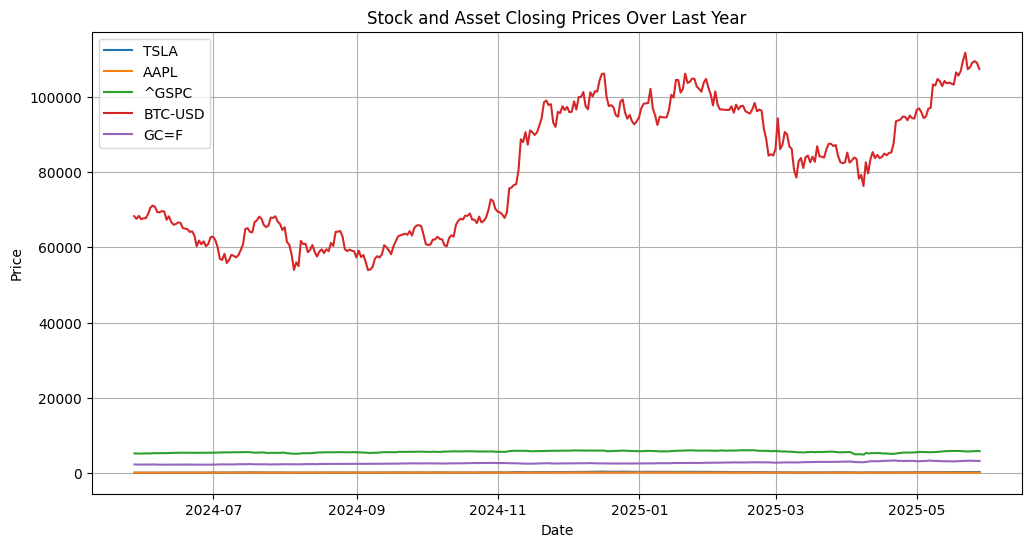

In [9]:
plt.figure(figsize=(12,6))
for symbol in symbols:
    plt.plot(data_dict[symbol].index, data_dict[symbol]['Close'], label=symbol)
plt.title("Stock and Asset Closing Prices Over Last Year")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()



## 📈 Normalized Plot of Closing Prices
Since the absolute price ranges differ greatly (e.g., BTC vs. TSLA), we normalize prices by dividing each by its initial value. This allows for comparing relative performance over time.


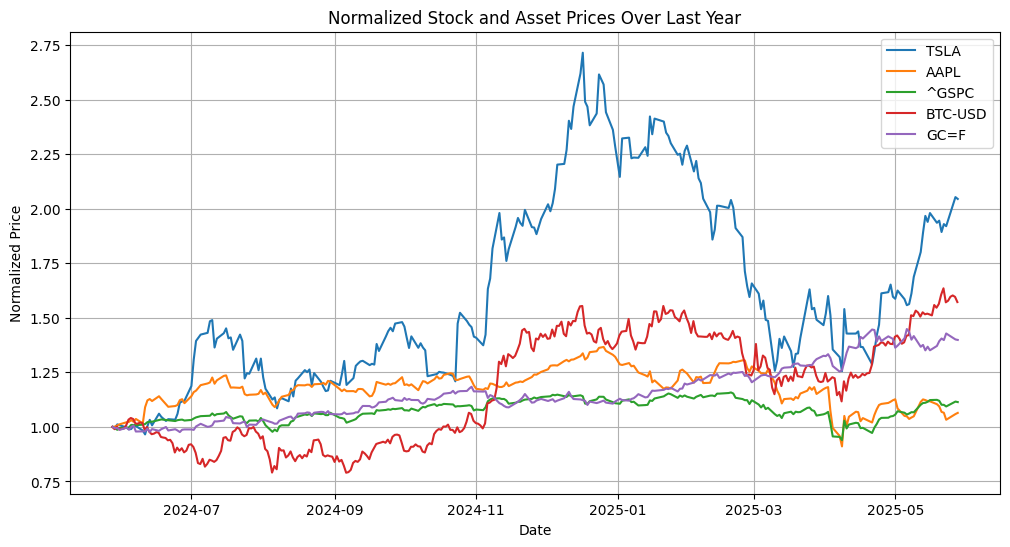

In [10]:
# 📈 Normalized Plot of Closing Prices (in terms of Return)

# Set the figure size for the plot
plt.figure(figsize=(12,6))

# Iterate over each stock symbol
for symbol in symbols:
    # Copy the data for the current symbol
    data = data_dict[symbol].copy()
    # Normalize to first price
    data['Normalized'] = data['Close'] / data['Close'].iloc[0]
    # Plot the normalized prices
    plt.plot(data.index, data['Normalized'], label=symbol)

# Set the title of the plot
plt.title("Normalized Stock and Asset Prices Over Last Year")
# Label the x-axis
plt.xlabel("Date")
# Label the y-axis
plt.ylabel("Normalized Price")
# Show the legend
plt.legend()
# Display grid lines
plt.grid()
# Render the plot
plt.show()

## 📊 2. Candlestick Charts (Price Action)

In [11]:
for symbol in symbols:
    data = data_dict[symbol]
    fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'], high=data['High'],
                low=data['Low'], close=data['Close'])])
    fig.update_layout(title=f'{symbol} Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
    fig.show()

## 📈 Histogram of Daily Returns
We calculate daily returns as the percentage change of closing prices and plot their distribution for each symbol.

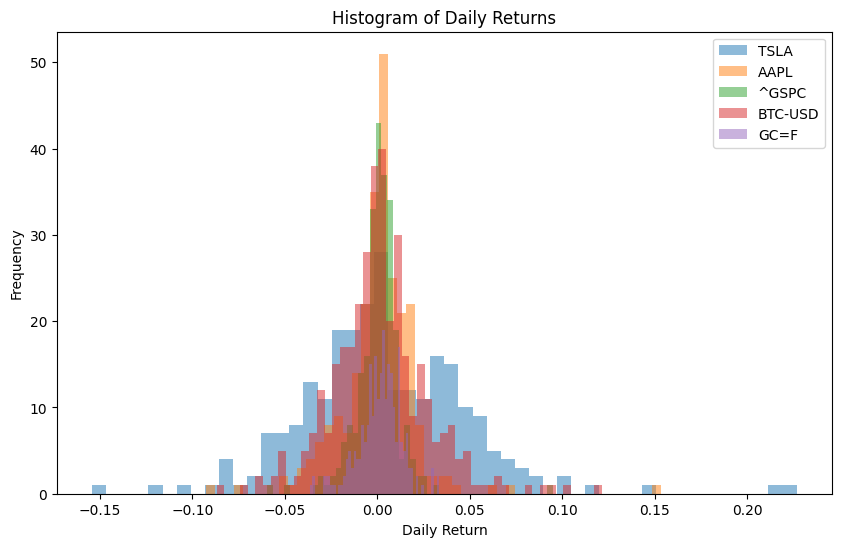

In [12]:
plt.figure(figsize=(10,6))
for symbol in symbols:
    data = data_dict[symbol].copy()
    data['Return'] = data['Close'].pct_change()
    data = data.dropna()  # Ensure no NaNs
    plt.hist(data['Return'], bins=50, alpha=0.5, label=symbol)
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## 📦 Box Plot of Daily Returns
We calculate daily returns for each symbol and create a box plot to show their distribution and outliers.


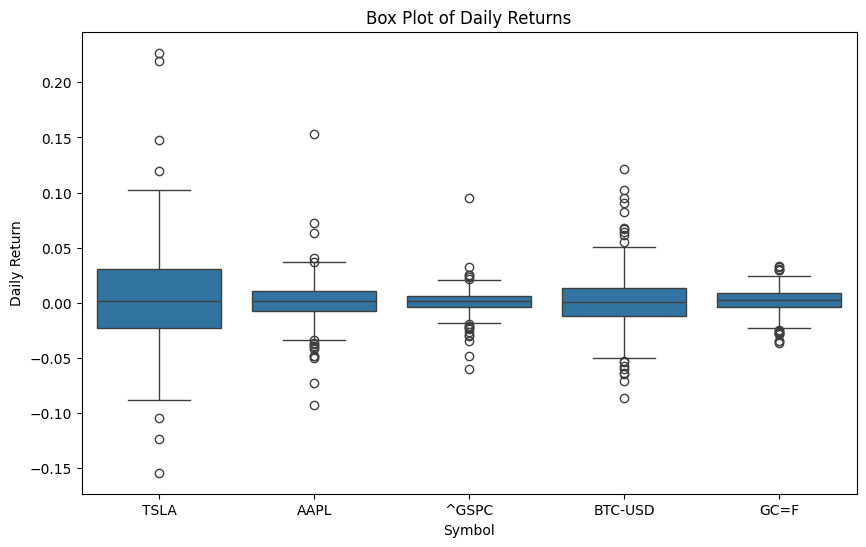

In [13]:
# Recalculate daily returns as a long-form DataFrame
returns_list = []
for symbol in symbols:
    data = data_dict[symbol].copy()
    data['Return'] = data['Close'].pct_change()
    returns = data[['Return']].dropna().reset_index()
    returns['Symbol'] = symbol
    returns_list.append(returns)

# Concatenate into one DataFrame
returns_df = pd.concat(returns_list, ignore_index=True)

# Plot box plot using Seaborn with x=symbol and y=return
plt.figure(figsize=(10,6))
sns.boxplot(x='Symbol', y='Return', data=returns_df)
plt.title("Box Plot of Daily Returns")
plt.ylabel("Daily Return")
plt.show()

## 🔥 Correlation Heatmap of Weekly Returns
This improved version resamples data to weekly frequency and uses forward filling to reduce missing data issues. It removes rows with no valid data across all symbols, providing a clearer and more complete correlation matrix.

## 📚 Understanding Correlation
Correlation is a way to see if two things (like stock prices) move together. If two stocks go up and down together, they have a positive correlation. If one goes up when the other goes down, they have a negative correlation. If they move randomly with no pattern, they have no correlation. In this heatmap, we use color to show how strong the connection is between different stocks and assets. Red means a strong negative relationship, blue means a strong positive relationship, and white means no relationship.


Missing values per column before cleaning:
TSLA       54
AAPL       54
^GSPC      54
BTC-USD    54
GC=F       54
dtype: int64
Shape of cleaned DataFrame: (104, 5)
Correlation matrix calculated:
             TSLA      AAPL     ^GSPC   BTC-USD      GC=F
TSLA     1.000000  0.460229  0.553267  0.219695  0.019772
AAPL     0.460229  1.000000  0.662389 -0.025104 -0.014020
^GSPC    0.553267  0.662389  1.000000  0.224394  0.079780
BTC-USD  0.219695 -0.025104  0.224394  1.000000  0.021338
GC=F     0.019772 -0.014020  0.079780  0.021338  1.000000


/var/folders/n_/bd_09xms0sbgcqdnd2kmyk7m0000gn/T/ipykernel_56439/2933951853.py:17: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



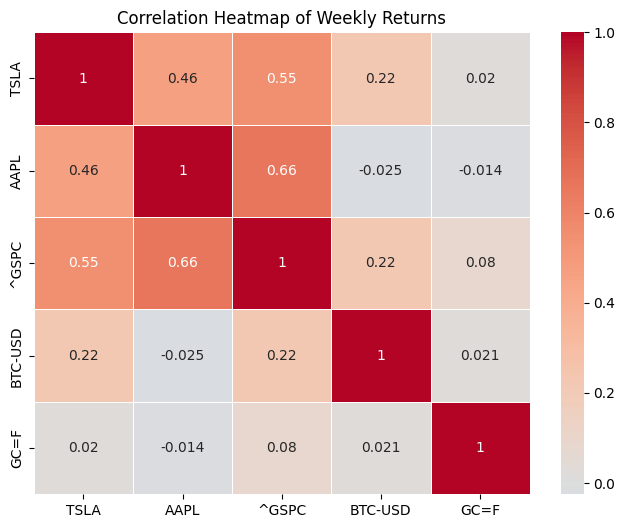

In [14]:
# Recalculate weekly returns for each symbol
returns_data = {}
for symbol in symbols:
    data = data_dict[symbol].copy()
    data = data.resample('W').last()  # Resample to weekly frequency
    data['Return'] = data['Close'].pct_change()
    returns_data[symbol] = data['Return']

# Combine into DataFrame
df_returns = pd.DataFrame(returns_data)

# Print missing values before cleaning
print("Missing values per column before cleaning:")
print(df_returns.isna().sum())

# Option: Forward-fill missing returns for consistency
df_returns_filled = df_returns.fillna(method='ffill')

# Drop rows where all symbols are NaN after filling
df_returns_clean = df_returns_filled.dropna(how='all')

print(f"Shape of cleaned DataFrame: {df_returns_clean.shape}")

if df_returns_clean.shape[0] > 0 and df_returns_clean.shape[1] > 1:
    corr_matrix = df_returns_clean.corr()
    print("Correlation matrix calculated:")
    print(corr_matrix)

    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
    plt.title("Correlation Heatmap of Weekly Returns")
    plt.show()
else:
    print("Not enough valid data to plot correlation matrix. Consider adjusting the data or filling strategies.")

## 🔍 6. Scatter Plots of Weekly Returns
Scatter plots are great for visualizing how two assets' returns relate to each other.  
- Each point shows a week’s return for two different symbols (e.g., Tesla vs. Bitcoin).  
- If points form a clear upward or downward line, the returns move together (positive or negative correlation).  
- If points are scattered randomly, it means there’s no strong relationship between the two.  
This helps us **visually understand correlation**, before we look at the correlation matrix.


Weekly returns shape: (104, 5)


/var/folders/n_/bd_09xms0sbgcqdnd2kmyk7m0000gn/T/ipykernel_56439/3451754491.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



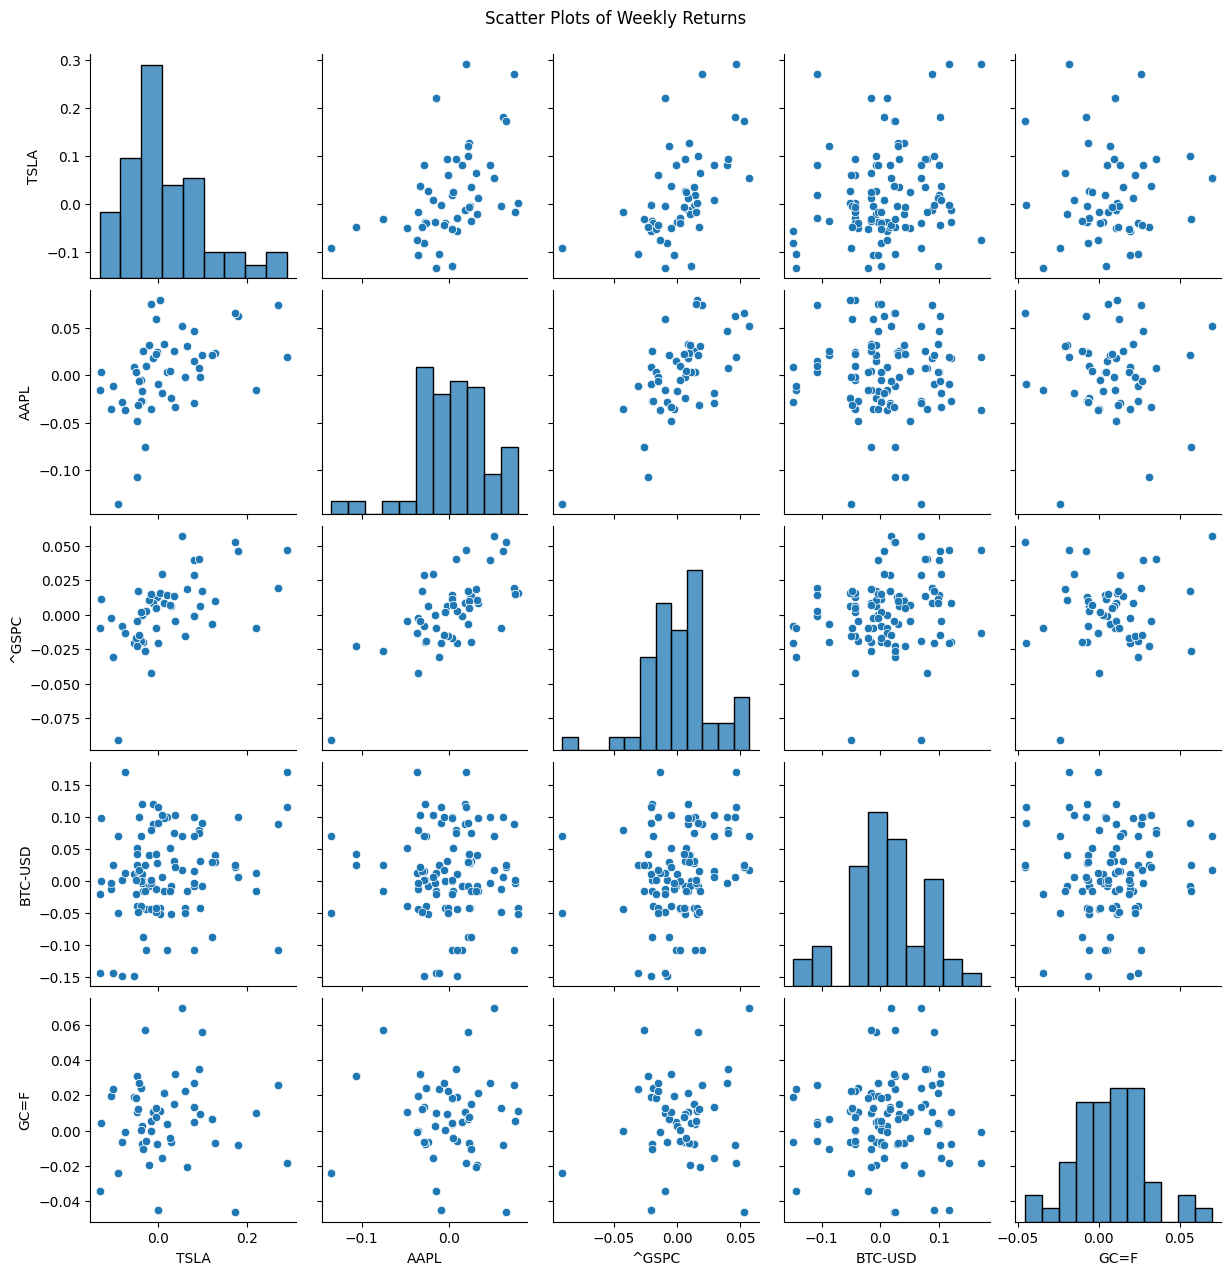

In [15]:
# Recalculate weekly returns for each symbol
returns_data = {}
for symbol in symbols:
    data = data_dict[symbol].copy()
    data = data.resample('W').last()
    data['Return'] = data['Close'].pct_change()
    returns_data[symbol] = data['Return']

# Combine into DataFrame with Date index
import pandas as pd
weekly_returns = pd.DataFrame(returns_data)

# Forward fill missing data (for weekends, holidays)
weekly_returns_filled = weekly_returns.fillna(method='ffill')

# Drop rows where all symbols are NaN
weekly_returns_clean = weekly_returns_filled.dropna(how='all')

# Check if there is valid data
print("Weekly returns shape:", weekly_returns_clean.shape)

# Plot scatter matrix
import seaborn as sns
import matplotlib.pyplot as plt

if weekly_returns_clean.shape[1] > 1 and weekly_returns_clean.shape[0] > 0:
    sns.pairplot(weekly_returns_clean)
    plt.suptitle("Scatter Plots of Weekly Returns", y=1.02)
    plt.show()
else:
    print("Not enough data for scatter plots.")

## 📈 7. Moving Averages (20-week, 50-week)
A moving average smooths out price data to show trends.  
- **20-week moving average (MA20)** is the average closing price over the past 20 weeks.  
- **50-week moving average (MA50)** does the same for 50 weeks.  
When the short-term average (MA20) crosses above the long-term (MA50), it can indicate a bullish trend, and vice versa.  
This helps traders spot long-term market direction.


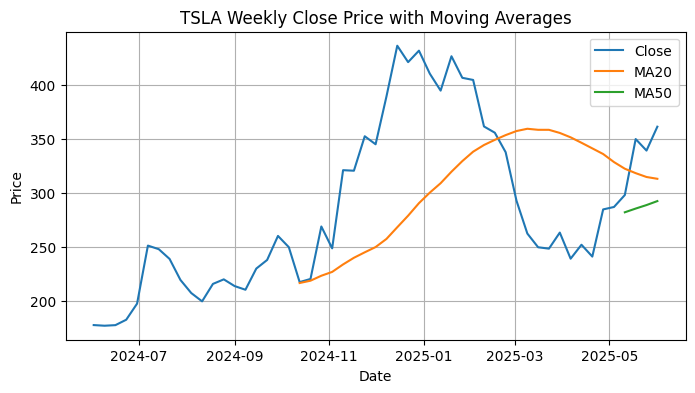

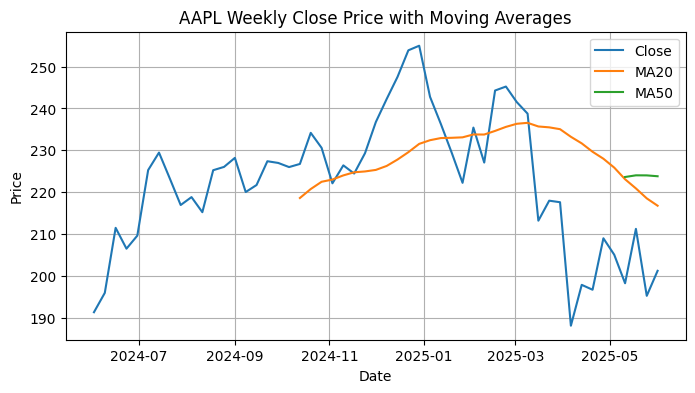

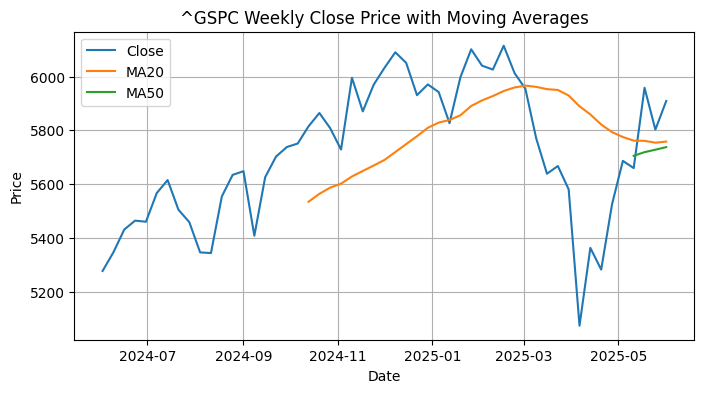

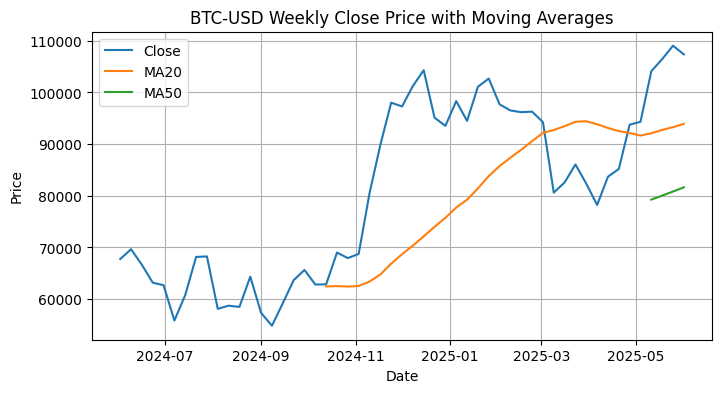

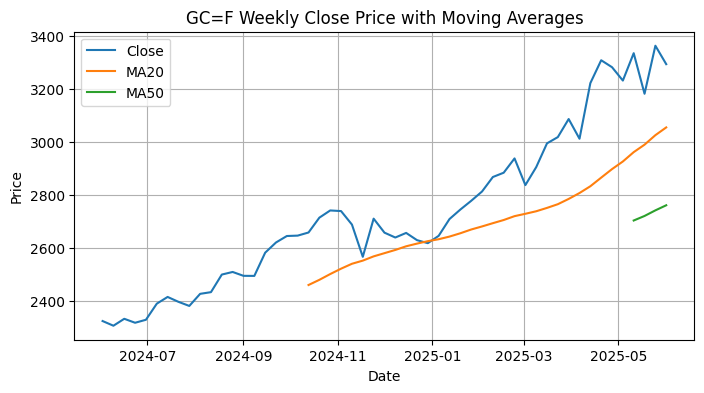

In [16]:
for symbol in symbols:
    data = data_dict[symbol].copy()
    data = data.resample('W').last()
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['MA50'] = data['Close'].rolling(window=50).mean()

    # Create a smaller figure
    plt.figure(figsize=(8,4))

    plt.plot(data.index, data['Close'], label='Close')
    plt.plot(data.index, data['MA20'], label='MA20')
    plt.plot(data.index, data['MA50'], label='MA50')

    plt.title(f"{symbol} Weekly Close Price with Moving Averages")
    plt.xlabel("Date") # Added xlabel for clarity
    plt.ylabel("Price") # Added ylabel for clarity
    plt.legend()
    plt.grid(True) # Using True for clarity
    plt.show()

## 📊 8. Weekly Trading Volume
Trading volume shows how much of an asset was traded in a week.  
- High volume can indicate strong interest and liquidity.  
- Low volume can indicate weak interest or illiquidity.  
This is important because volume often accompanies big price moves or reversals.

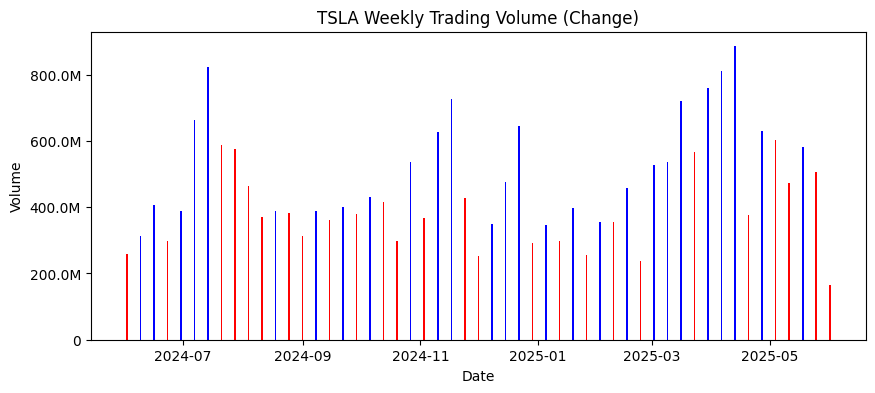

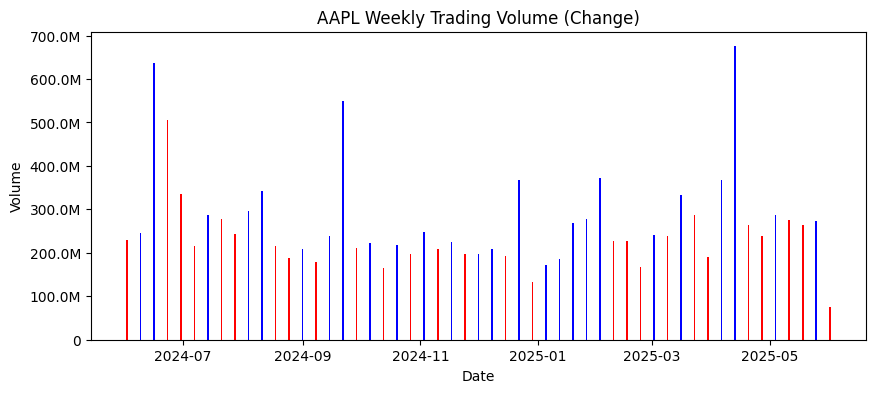

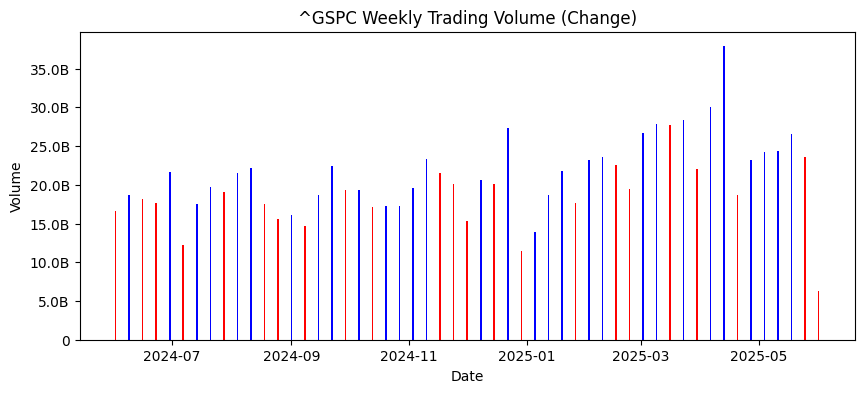

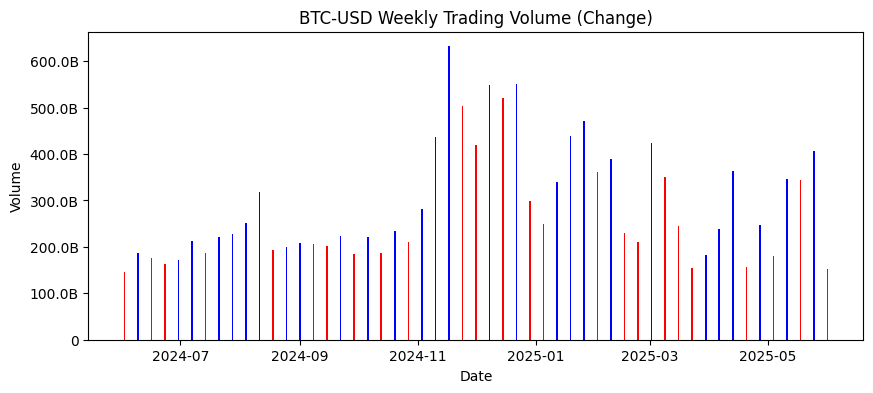

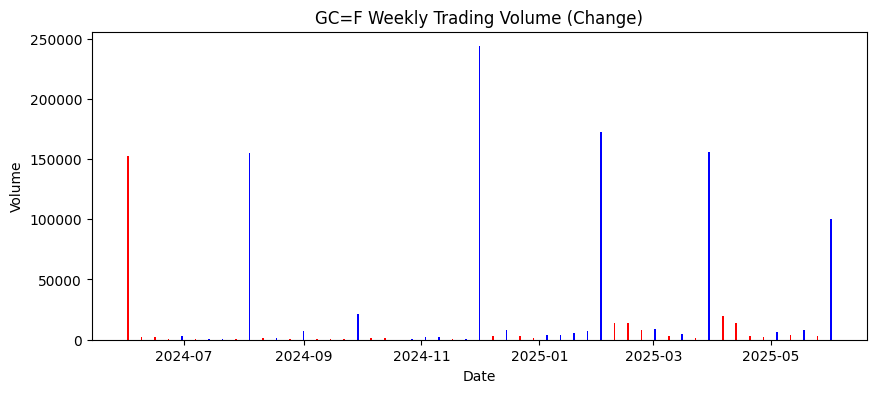

In [17]:
import matplotlib.ticker as mticker

def volume_formatter(x, pos):
    """
    Formats the y-axis labels for volume in Millions (M) or Billions (B).
    """
    if x >= 1e9:
        return f'{x / 1e9:.1f}B'
    elif x >= 1e6:
        return f'{x / 1e6:.1f}M'
    else:
        return f'{x:.0f}'

for symbol in symbols:
    data = data_dict[symbol].copy()
    data = data.resample('W').sum() # Resample to weekly frequency and sum volume

    # Calculate the percentage change in volume from the previous week
    data['Volume_Change'] = data['Volume'].pct_change()

    # Determine color based on volume change (Blue for increase, Red for decrease)
    colors = ['blue' if change > 0 else 'red' for change in data['Volume_Change']]

    plt.figure(figsize=(10,4))
    plt.bar(data.index, data['Volume'], color=colors)

    # Apply the custom formatter to the y-axis
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(volume_formatter))

    plt.title(f"{symbol} Weekly Trading Volume (Change)")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.show()

## 🌊 9. 20-Week Rolling Volatility
Volatility shows how much the price returns vary (how risky the asset is).  
- **High volatility** means the price changes a lot; it’s riskier.  
- **Low volatility** means the price is stable.  
We use a rolling window of 20 weeks to measure the standard deviation of returns.  
This shows how volatility changes over time, which helps with risk assessment.

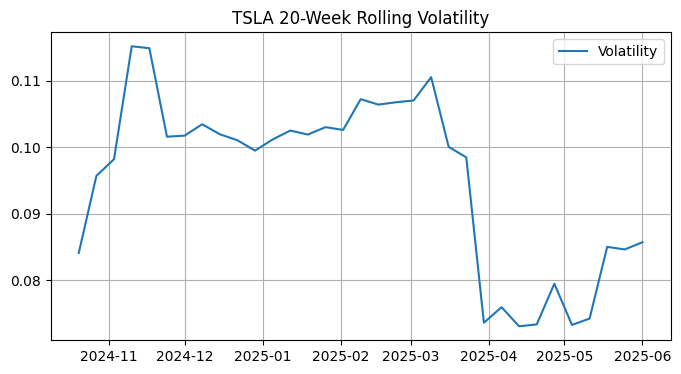

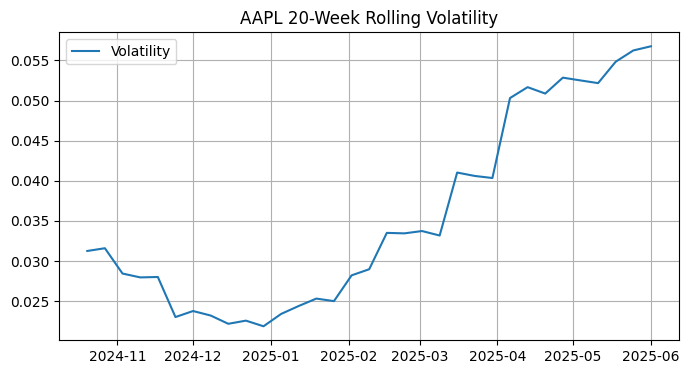

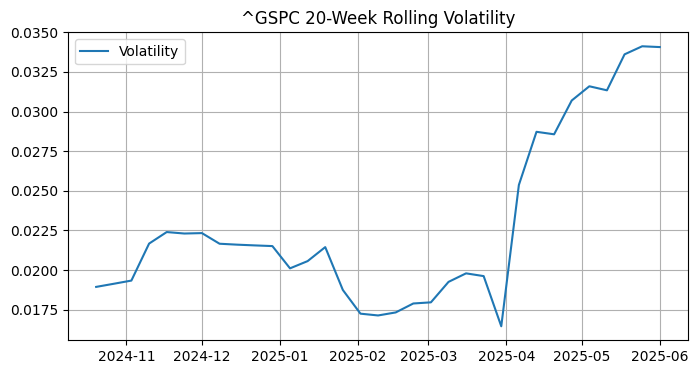

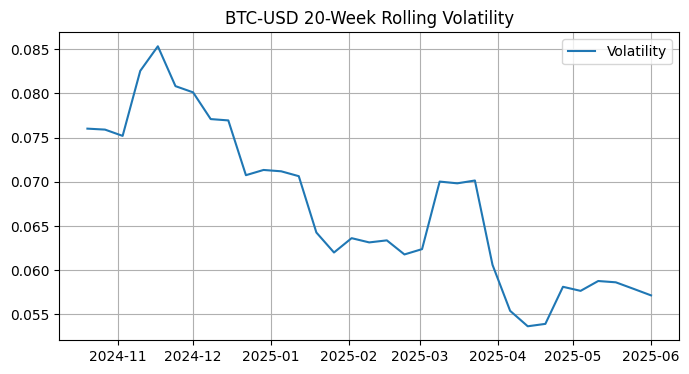

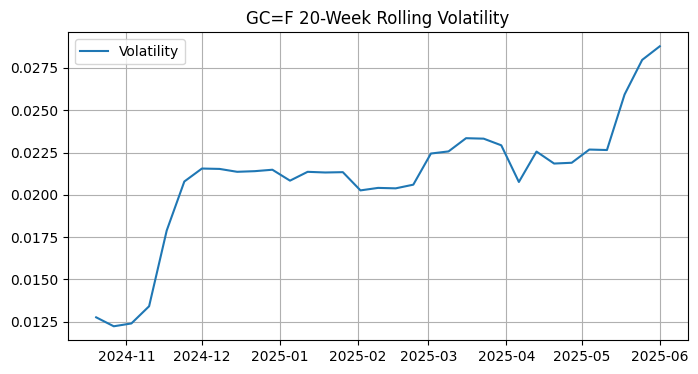

In [18]:
for symbol in symbols:
    data = data_dict[symbol].copy()
    data = data.resample('W').last()
    data['Return'] = data['Close'].pct_change()
    data['Volatility'] = data['Return'].rolling(window=20).std()
    # The loop structure here was slightly duplicated in the original code,
    # ensuring we plot correctly with the smaller figure size.
    plt.figure(figsize=(8, 4)) # Reduced figure size
    plt.plot(data.index, data['Volatility'], label='Volatility')
    plt.title(f"{symbol} 20-Week Rolling Volatility")
    plt.legend()
    plt.grid()
    plt.show()